# Проверка гипотез
Компания предоставила три датасета с данными о пользователях сервиса, их поездках за один год, а также стоимости услуг в подписках. 
Необходимо проанализировать демографию пользователей и особенности использования самокатов, а также определить возможную выгоду от распространения платной подписки на самокаты.

# Описание данных

Таблица с пользователями `users_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `name` — имя пользователя.

- `age` — возраст.

- `city` — город.

- `subscription_type` — тип подписки: `free`, `ultra`.

Таблица с поездками `rides_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `distance` — расстояние в метрах, которое пользователь проехал в текущей сессии.

- `duration` — продолжительность сессии в минутах, то есть время с того момента, как пользователь нажал кнопку «Начать поездку», до того, как он нажал кнопку «Завершить поездку».

- `date` — дата совершения поездки.

Таблица с подписками `subscriptions_go.csv`

- `subscription_type` — тип подписки.

- `minute_price` — стоимость одной минуты поездки по этой подписке.

- `start_ride_price` — стоимость начала поездки.

- `subscription_fee` — стоимость ежемесячного платежа.

---
## 1. Загрузка данных
1.1 Импорт библиотек


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

### 1.2 Чтение данных
- https://code.s3.yandex.net/datasets/users_go.csv
- https://code.s3.yandex.net/datasets/rides_go.csv
- https://code.s3.yandex.net/datasets/subscriptions_go.csv

In [ ]:
df_users_go = pd.read_csv("https://code.s3.yandex.net/datasets/users_go.csv")
df_rides_go = pd.read_csv("https://code.s3.yandex.net/datasets/rides_go.csv")
df_subscriptions_go = pd.read_csv("https://code.s3.yandex.net/datasets/subscriptions_go.csv")

### 1.3 Просмотр данных


In [ ]:
display(df_users_go.head())
display (df_rides_go.head())
display  (df_subscriptions_go.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### 1.4 Подсчёт строк

In [ ]:
display(df_users_go.shape[0],
df_rides_go.shape[0],
df_subscriptions_go.shape[0])

1565

18068

2

---
## 2. Знакомство с данными и их предварительная подготовка


### 2.1 Определение типов данных

In [5]:
df_rides_go.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

### 2.2 Преобразование формата даты


In [6]:
df_rides_go['date']=pd.to_datetime(df_rides_go['date'])

### 2.3 Создание столбца с месяцем

In [7]:
df_rides_go['month'] = df_rides_go['date'].dt.month

### 2.4 Поиск дублей и пропусков

In [ ]:
# Количество пропусков во всем DataFrame
num_missing = df_users_go.isnull().sum().sum()

# Количество дубликатов
num_duplicates = df_users_go.duplicated().sum()

# Вывод результатов через пробел
print(f"{num_missing} {num_duplicates}")

0 31


### 2.5 Заполнение пропусков и удаление дублей


In [9]:
# Заполнение пропущенных значений нулями
# Удаление дубликатов
df_users_go = df_users_go.fillna(0)
df_users_go = df_users_go.drop_duplicates()

### 2.6 Округление длительности поездки

In [ ]:
# Округление значения в столбце 'duration' до ближайшего целого
df_rides_go['duration'] = df_rides_go['duration'].apply(round)

# Приведение типа к целочисленному
df_rides_go['duration'] = df_rides_go['duration'].astype(int)


## 3. Исследовательский анализ данных (EDA)


### Задача 3.1 Количество пользователей по городам.


In [ ]:
# Подсчет количества уникальных пользователей в каждом городе
#users_by_city_count = df_users_go.groupby('city')['user_id'].nunique()
# Сортировка по убыванию
#users_by_city_count = users_by_city_count.sort_values(ascending=False)
# Вывод результата
#print(users_by_city_count)
# value_counts() считает количество вхождений каждого значения, 
# и правильнее сначала посчитать уникальных пользователей по каждому городу, если есть дубликаты
# и если одно и тоже id может встречаться в нескольких городах в конкретных данных

users_by_city_count = df_users_go['city'].value_counts()
print(users_by_city_count)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


### 3.2 Количество пользователей подписки

In [ ]:
# с помощью value_counts() считаем какие (free и ultra)
# и сколько встречается значений в столбце subscription_type
subscription_type_count = df_users_go['subscription_type'].value_counts()
print(subscription_type_count)

free     835
ultra    699
Name: subscription_type, dtype: int64


### 3.3 Круговая диаграмма
С процентом пользователей с `free` и `ultra` подпиской. 

- **Заголовок.**  `title`- `'Соотношение пользователей с подпиской и без подписки'`.
- **Процентные метки.**  `autopct='%.0f%%'` для отображения процентных значений на диаграмме. 
- **Подпись оси Y.**  `(ylabel='')`
- **Цвета секторов.**  `colors`


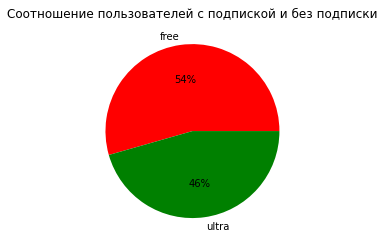

In [ ]:
subscription_type_count.plot(
    kind= 'pie',
    title='Соотношение пользователей с подпиской и без подписки',
    autopct='%.0f%%',
    ylabel='',
    colors= ['red', 'green']
)

plt.show()


### 3.4 Гистограмма возрастов


1. Определить количество бинов `n_bins` как разницу между максимальным и минимальным значениями в столбце `age`.
2. Использовать метод `hist()` для столбца `df_users_go['age']`.
3. Установить количество бинов через параметр `bins=n_bins`.
4. Назначить заголовок графика как `'Возраст пользователей'` с помощью `plt.title()`.
5. Установить подпись оси X как `'Возраст'` с помощью `plt.xlabel()`.
6. Вызвать `plt.show()` для визуального отображения гистограммы.

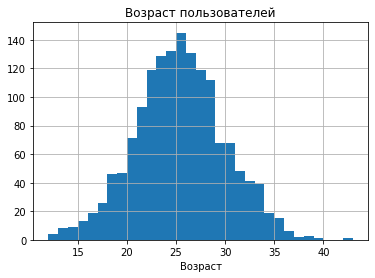

In [ ]:
# Определить количество бинов n_bins, 
# как разницу между максимальным и минимальным значениями в столбце age.
n_bins = int(df_users_go['age'].max() - df_users_go['age'].min())
df_users_go['age'].hist(bins=n_bins)

plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.show()
# Строим гистограмму по-другому
#df_users_go['age'].plot(kind='hist', bins=n_bins)
#plt.title('Возраст пользователей')
#plt.xlabel('Возраст')
#plt.ylabel('Количество')
#plt.show()

### 3.5 Несовершеннолетние пользователи


In [ ]:
# Создание логической маски
mask =df_users_go['age'] < 18
# Подсчет количества пользователей < 18
count_users = mask.sum()
#print(count_users)
# Подстчет общего числа пользователей
total_users = df_users_go.shape[0]
#print(total_users)
# Расчет доли
users_under_18_ratio = int((count_users / total_users)*100)

print(f'Доля несовершеннолетних пользователей самокатов составляет {users_under_18_ratio}%.')

Доля несовершеннолетних пользователей самокатов составляет 5%.


### 3.6 Характеристики длительности поездки
Длительность поездки является важной метрикой в работе сервиса проката самокатов. Если средняя длительность поездок будет слишком высокой, самокаты будут быстрее выходить из строя. Если слишком низкой, значит, клиентам что-то не нравится в сервисе.


1. Расчитать среднее значение и стандартное отклонение длительности поездки. 
2. Рассчитать 25-й и 75-й процентили длительности поездки.



In [ ]:
duration_mean = int(round(df_rides_go['duration'].mean(),0))
duration_std = int(df_rides_go['duration'].std())

duration_pct25 = int(df_rides_go['duration'].quantile(0.25))
duration_pct75 = int(df_rides_go['duration'].quantile(0.75))

print(f'Средняя длительность поездки {duration_mean} минут со стандартным отклонением {duration_std}. Основная часть поездок занимает от {duration_pct25} до {duration_pct75} минут.')

Средняя длительность поездки 18 минут со стандартным отклонением 6. Основная часть поездок занимает от 14 до 22 минут.



## 4. Объединение данных


### 4.1 Объединение таблицы пользователей и поездок
Объединить датафреймы с информацией о пользователях `df_users_go` и поездках `df_rides_go`

In [18]:
df=df_users_go.merge(df_rides_go, on='user_id', how='left')

### 4.2 Присоединение информации о подписках
Присоединить информацию о подписках из `df_subscriptions_go`


In [19]:
df= df.merge(df_subscriptions_go, on='subscription_type', how ='left')

### 4.3. Размеры объединённого датафрейма

In [20]:
# Выводим первые строки датафрейма
display(df.head())

# Выводим количество строк и столбцов в объединённом датафрейме
n_rows, n_cols = df.shape
print(f'В полученном датафрейме {n_rows} строк и {n_cols} столбцов.')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26,2021-08-28,8,6,0,199


В полученном датафрейме 18068 строк и 12 столбцов.


### 4.4 Отдельные датафреймы для пользователей с подпиской и без
Два вспомогательных датафрейма на основе `df`: первый только для пользователей с подпиской `df_ultra` и второй только для пользователей без подписки `df_free`

In [21]:
# Для подписок "free"
df_free = df[df['subscription_type'] == 'free']

# Для подписок "ultra"
df_ultra = df[df['subscription_type'] == 'ultra']

### 4.5 Гистограмма длительности поездок для обоих групп


1. Размер графика: 15 по горизонтали и 5 по вертикали. Использовать `plt.figure(figsize=(15, 5))`.
2. Отобразить данные из столбца `duration` датафрейма `df_free` с помощью метода `hist()`, задав количество бинов `bins=30` и метку `label='free'`.
3. Отобразить данные из столбца `duration` датафрейма `df_ultra` с помощью метода `hist()`, также задав количество бинов `bins=30` и метку `label='ultra'`.
4. Установить подпись оси X как `'Длительность поездки, мин.'`, используя `plt.xlabel()`.
5. Задать заголовок графика как `'Гистограмма распределения длительности поездок'` методом `plt.title()`.
6. Добавить легенду для различения категорий на графике с использованием `plt.legend()`.
7. Вызвать `plt.show()` для показа графика пользователю.


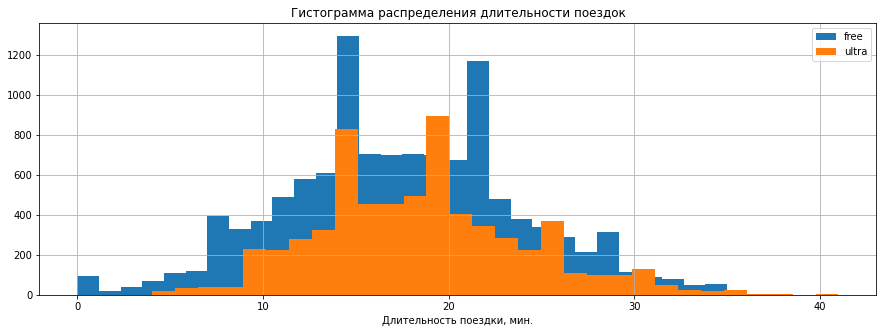

Средняя длительность поездки для пользователей без подписки 17 мин, а для пользователей с подпиской 19 мин


In [22]:
# Гистограмма длительности поездки для пользователей с подпиской и без
plt.figure(figsize=(15, 5))
df_free['duration'].hist(bins=30, label='free')
df_ultra['duration'].hist(bins=30, label='ultra')
plt.title('Гистограмма распределения длительности поездок')
plt.xlabel('Длительность поездки, мин.')
plt.legend(loc='upper right')  #'upper left', 'lower right', 'center'
plt.show() 

# Расчет и вывод на экран средней длительности поездки для пользователей с подпиской и без
mean_duration_free = int(round(df_free['duration'].mean(),0))
mean_duration_ultra = int(round(df_ultra['duration'].mean(),0))
print(f'Средняя длительность поездки для пользователей без подписки {mean_duration_free} мин, а для пользователей с подпиской {mean_duration_ultra} мин')

На графике видно, что профили длительности поездок у пользователей с разной подпиской схожи. У пользователей без платной подписки бОльший разброс по времени поездок, чем у пользователей с платной подпиской Ultra.

---
## 5. Подсчёт выручки
Данные о количестве и длительности поездок объединены с ценами и тарифами, а значит, теперь есть всё необходимое, чтобы рассчитать выручку.

### 5.1 Данные сгруппированные по нужным колонкам
не должны использоваться групповые индексы (опция `as_index=False`).


In [23]:
df_gp = df.groupby(['user_id', 'name', 'subscription_type', 'month'], as_index=False)

### 5.2 Подсчёт агрегированных метрик
`df_agg`:
- `total_distance` — сумма значений в столбце `distance`.
- `total_duration` — сумма значений в столбце `duration`.
- `rides_count` — количество элементов в столбце `duration`.
- `subscription_type` — первое значение в группе для столбца `subscription_type`.
- `minute_price` — первое значение в группе для столбца `minute_price`.
- `start_ride_price` — первое значение в группе для столбца `start_ride_price`.
- `subscription_fee` — первое значение в группе для столбца `subscription_fee`.

In [24]:
df_agg = df_gp.agg( 
    total_distance=('distance', 'sum'),
    total_duration=('duration', 'sum'),
    rides_count= ('duration', 'count'),
    #первое значение в группе для столбца
    subscription_type= ('subscription_type', 'first'),
    minute_price=('minute_price', 'first'),
    start_ride_price=('start_ride_price', 'first'),
    subscription_fee=('subscription_fee', 'first')
)

###5.3 Функция для подсчёта выручки
calculate_monthly_revenue(row) для расчёта месячной выручки по формуле:

`monthly_revenue` = `start_ride_price` * `rides_count` + `minute_price` * `total_duration` + `subscription_fee`

В качестве входных данных функция будет принимать одну строку `row` дф

Здесь:
- `start_ride_price * rides_count` — выручка от начала каждой поездки.
- `minute_price * total_duration` — выручка за время использования.
- `subscription_fee` — фиксированная выручка от подписок.

In [25]:
def calculate_monthly_revenue(row):
    # расчёт месячной выручки по формуле:
    monthly_revenue = (
        row['start_ride_price'] * row['rides_count'] +
        row['minute_price'] * row['total_duration'] +
        row['subscription_fee']
    )
    #Внутри ф-и обращаемся к значениям стб через row['название_столбца']
    return monthly_revenue

### 5.4 Создание столбца с месячной выручкой на пользователя
Новый стб с месячной выручкой на пользователя `monthly_revenue`

In [26]:
# Исп-м .apply() с аргументом axis=1, чтобы применить ф-ию к каждой строке DF
df_agg['monthly_revenue']=df_agg.apply(calculate_monthly_revenue, axis=1)

### 5.5 Поиск пользователя с максимальной выручкой


In [27]:
# Найти user_id с максимальной суммарной выручкой
top_user = df_agg.groupby('user_id')['monthly_revenue'].sum().idxmax()

# 2. Получить все записи этого пользователя
user_info = df_agg.query('user_id == @top_user')[['user_id', 'name', 'month', 'rides_count'
                                                   , 'monthly_revenue']]
display(user_info)

,user_id,name,month,rides_count,monthly_revenue
8877,1236,Александр,1,2,228
8878,1236,Александр,2,3,614
8879,1236,Александр,3,5,762
8880,1236,Александр,4,1,202
8881,1236,Александр,5,3,574
8882,1236,Александр,6,1,282
8883,1236,Александр,7,1,290
8884,1236,Александр,8,2,452
8885,1236,Александр,9,1,122
8886,1236,Александр,10,3,430



## 6. Проверка гипотез

### 6.1 Вспомогательная функция для интерпретации результатов
 `print_stattest_results(p_value, alpha)` будет интерпретировать результаты статистического теста на основе p-value и заданного уровня значимости (α-уровня). 


In [ ]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    if p_value < alpha:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Принимаем альтернативную гипотезу.')
    else:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.')
print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

Полученное значение p_value=0.0001 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Полученное значение p_value=0.1 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


### 6.2 Длительность для пользователей с подпиской и без

Важно понять, тратят ли пользователи с подпиской больше времени на поездки?
- Нулевая гипотеза (Н0): Среднее время поездки у пользователей с подпиской и без подписки одинаковое.
- Альтернативная гипотеза (Н1): Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.

1. Используем `df_ultra` и `df_free` стб `duration` 
2. Рассчитать значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
3. В конце дополнительно рассчитайте среднюю длительность поездки для тарифов `ultra` и `free`, округлив её до двух знаков после точки стандартной функцией `round()`.

In [ ]:
ultra_duration = df_ultra['duration']
free_duration =df_free['duration']

results = st.ttest_ind(ultra_duration, free_duration, alternative = 'greater')
p_value = results.pvalue
print_stattest_results(p_value, alpha=0.05)

ultra_mean_duration =round(df_ultra['duration'].mean(),2)
free_mean_duration = round(df_free['duration'].mean(),2)

print(f'Средняя длительность поездки тарифа Ultra {ultra_mean_duration}')
print(f'Средняя длительность поездки тарифа Free {free_mean_duration}')

Полученное значение p_value=3.1600689435611813e-35 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя длительность поездки тарифа Ultra 18.55
Средняя длительность поездки тарифа Free 17.39


### 6.3 Длительность поездки: больше или меньше критического значения

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?

- Нулевая гипотеза (Н0): Средняя дистанция поездки у пользователей с подпиской равна 3130 м.
- Альтернативная гипотеза (Н1): Средняя дистанция поездки у пользователей с подпиской больше 3130 м.

In [ ]:
# Определяем нулевую гипотезу - крит. знач. для проверки
null_hypothesis = 3130
# Получаем данные о дистанциях поездок пользователей с подпиской
ultra_distance = df_ultra['distance']
# Уровень значимости 
alpha = 0.05
# Выполняем односторонний t-тест
# lternative ='greater' - правосторонняя гипотеза, когда H1 > Больше H0
results = st.ttest_1samp(ultra_distance, null_hypothesis, alternative ='greater')
p_value = results.pvalue
# Ф-я для интерпритации результатов
print_stattest_results(p_value, alpha)

Полученное значение p_value=0.9195368847849785 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


### 6.4 Прибыль от пользователей с подпиской и без

- Нулевая гипотеза (Н0): Средняя месячная выручка у пользователей с подпиской и без подписки одинаковая.
- Альтернативная гипотеза (Н1): Средняя месячная выручка у пользователей с подпиской выше, чем у пользователей без подписки.


1. Используем агрегированные данные из датафрейма `df_agg` данные о месячной выручке от каждого пользователя — `monthly_revenue`.
2. Рассчет `p_value` односторонний t-тест.
3. Средняя выручку для тарифов `ultra` и `free`, округлив её до целого стандартной функцией `round()`.

In [ ]:
# Данные о месячной выручке от каждого пользователя с условием, что в стб значение ultra или free
revenue_ultra = df_agg[df_agg['subscription_type']== 'ultra']['monthly_revenue']
revenue_free = df_agg[df_agg['subscription_type']== 'free']['monthly_revenue']
# применяем тест для проверки 2-х  не зав ? гипотез
results = st.ttest_ind(revenue_ultra, revenue_free, alternative ='greater')
p_value = results.pvalue
print_stattest_results(p_value)

mean_revenue_ultra = round(df_agg[df_agg['subscription_type']== 'ultra']['monthly_revenue'].mean())
mean_revenue_free = round(df_agg[df_agg['subscription_type']== 'free']['monthly_revenue'].mean())

print(f'Средняя выручка подписчиков Ultra {mean_revenue_ultra} руб')
print(f'Средняя выручка подписчиков Free {mean_revenue_free} руб')

Полученное значение p_value=1.7274069878387966e-37 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя выручка подписчиков Ultra 359.0 руб
Средняя выручка подписчиков Free 322.0 руб



## 7. Распределения

В компании возникла идея предлагать дополнительную скидку подписчикам, совершающим длительные поездки продолжительностью более 30 минут. Нужно оценить долю таких поездок.

### 7.1 Расчёт выборочного среднего и стандартного отклонения

In [38]:
# Вычисляем среднее значение
mu = df_ultra['duration'].mean()

# Вычисляем стандартное отклонение
sigma = df_ultra['duration'].std()

# Задаём целевое время
target_time = 30

# Делаем вывод
print(f'Средняя длительность поездки {round(mu, 1)}, стандартное отклонение {round(sigma)}.')

Средняя длительность поездки 18.5, стандартное отклонение 6.


### 7.2 Вычисление значения функции распределения в точке (CDF)
Если вычислить значение функции распределения в точке, это позволит узнать вероятность того, что случайная величина примет значение меньше заданного либо равное ему. Соответственно, если вы хотите ответить на вопрос о вероятности поездки более 30 минут, потребуется использовать CDF.

1. функция `norm()` из библиотеки SciPy для создания нормального распределения с параметрами `mu` и `sigma`.

2. Метод `cdf()` применяется ко времени `target_time` для получения вероятности того, что случайная величина будет меньше этого значения или равна ему. 

In [41]:
# Вычисляем вероятность того, что случайная величина будет меньше указанного значения или равна ему

duration_norm_dist  = st.norm(loc=mu, scale=sigma)
prob = round(1- duration_norm_dist.cdf(target_time), 3) # Используем CDF для нахождения накопленной вероятности

print(f'Вероятность поездки более 30 минут {prob}')

Вероятность поездки более 30 минут 0.02


### 7.3 Вероятность для интервала (CDF)
Коллеги посчитали, что процент пользователей, для которых будет показана скидка, недостаточно большой и вряд ли поможет в увеличении лояльности клиентов. Дополнительно вас просят проверить, какой процент пользователей совершает поездки в интервале от 20 до 30 минут. Возможно, именно для них стоит провести промоакцию?

 `low` и `high`, указывают на начало и конец интересующего временного интервала. 
2. Используем кумулятивную функцию распределения (CDF) для объекта `duration_norm_dist`, чтобы вычислить вероятность достижения верхней границы (`high`) и нижней границы (`low`).
3. Вычисляем вероятность попадания в интервал

In [44]:
# Определяем границы интервала
low = 20
high = 30

# Вычисляем вероятность попадания в интервал
prob_low = duration_norm_dist.cdf(low)
prob_high = duration_norm_dist.cdf(high)
prob_interval  = round(prob_high - prob_low, 3)


# Выводим результат
print(f'Вероятность того, что пользователь совершит поездку длительностью от {low} до {high} минут: {prob_interval}')

Вероятность того, что пользователь совершит поездку длительностью от 20 до 30 минут: 0.377


### 7.4 Определение критической дистанции поездок (PPF)
Длительные поездки могут негативно сказываться на сроке службы самоката. В связи с этим принято решение установить критическую дистанцию, превышение которой будет сопровождаться дополнительной платой. Для этого необходимо определить расстояние, которое превышается только в 10% поездок (90-й процентиль).

Нужно смоделировать распределение длительности поездок, предполагая, что оно подчиняется нормальному закону, и рассчитать критическую дистанцию, ниже которой находится 90% всех поездок.

Для этого:
1. Рассчитать среднюю дистанцию поездки для всех пользователей из датафрейма `df` (с подпиской и без)
2. Вычислить стд отклонение дистанции поездки `distance` 
3. Задайть значение переменной `target_prob`, равное `0.90`
4. Создать объект нормального распределения `distance_norm` с заданными значениями `mu` и `sigma`.
5. Применить к созданному нормальному распределению `distance_norm` метод `ppf()` 



In [48]:
# Вычисляем среднее значение
mu = df['distance'].mean()

# Вычисляем стандартное отклонение
sigma = df['distance'].std()

# Вероятность, для которой хотим найти значение (90% случаев)
target_prob = 0.90

# Создаём объект нормального распределения
distance_norm = st.norm(loc=mu, scale=sigma)

# Рассчитываем критическую дистанцию для заданного процентиля поездок
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % поездок имеют дистанцию ниже критического значения {critical_distance:.2f} М.')

90.0 % поездок имеют дистанцию ниже критического значения 4501.94 М.
